# Timeseries

---
**Overview.**  This notebook describes tools for working with data that has associated with it dates and times. Economists often call this "time series data". We start with functionality built into python itself, i.e. the `datetime` package. We then discuss how Pandas builds on these tools to add powerful time series capabilities to DataFrames.

**Outline**

- [Dates in python](#datetime): Covers the basics of working with dates and times in python
- [Dates in pandas](#pandas_dates): Shows how to use dates with pandas objects


**Note: requires internet access to run.**  

To run the code in this notebook, you need to have the quandl package installed. You can do this from the command line using:

```
pip install quandl --upgrade
```

---

In [1]:
import pandas as pd                    # data package
import matplotlib.pyplot as plt        # graphics module  
import datetime as dt                  # date and time module
import numpy as np

%matplotlib inline    
# Plot the stuff inline, also lets use this style
plt.style.use("ggplot")

# quandl package
import quandl

print('Today: ', dt.date.today())


# helper function to print info about dataframe
def df_info(df):
    print("Shape: ", df.shape)
    print("dtypes: ", df.dtypes.to_dict())
    print("index dtype: ", df.index.dtype)
    return pd.concat([df.head(3), df.tail(3)])

Today:  2017-12-11


## Dates in python <a id=datetime></a>

The date and time functionality in python comes from the built in `datetime` module. Notice above that we ran

```python
import datetime as dt
```

We've been using the `dt.date.today()` function throughout this course when we print the date at the top of our notebooks, but we haven't given it very much thought. Let's take a closer look now.

To start, let's see what the type of `dt.date.today()` is

In [2]:
today = dt.date.today()
print("the type of today is ", today)

the type of today is  2017-12-11


Given that we have an object of type `datetime.date` we can do things like ask for the day, month, and year

In [3]:
print("the day of the month is: ", today.day)
print("we are curretly in month number", today.month)
print("The year is", today.year)

the day of the month is:  11
we are curretly in month number 12
The year is 2017


### timedelta

Suppose that we wanted to construct a "days until" counter. To do this we will construct another `datetime.date` and use the `-` operator to find the differene between the other date and today.

In [5]:
# construct a date by hand
new_years_eve = dt.date(2017, 12, 31)

In [6]:
until_nye = new_years_eve - today

In [7]:
print(until_nye)

20 days, 0:00:00


We can get the number of days until new years eve by looking at `until_nye.days`

In [8]:
until_nye.days

20

**Exercise**: Write a python function named `days_until` that accepts one argument (a `datetime.date`) and returns the number of days between today and that date. Apply your function to 

- December 21, 2017 (day the UG project is due)
- Your birthday (HINT: unless your birthday is in late December, make sure to do 2017 as the year)

We could also construct a `datetime.timedelta` by hand and add it to an existing date. Here's an example to see how many days until I turn 40!

In [9]:
mike_bday = dt.date(1978, 3, 28)

# NOTE: add 10 for the 10 leap years between 1978 and 2019
fourty_years = dt.timedelta(days=365*40 + 10)

In [10]:
# check to make sure it is still April 25th
mike_bday + fourty_years

datetime.date(2018, 3, 28)

In [11]:
days_to_40 = (mike_bday + fourty_years - today).days

print("Mike will be 40 in {} days".format(days_to_40))

Mike will be 40 in 107 days


### datetime

Being able to work with dates and the difference between dates is very useful, but sometimes we need to also think about times. To do that, we will look to the `dt.datetime` module.

We can get the current date and time using `dt.datetime.now()`:

In [17]:
now = dt.datetime.now()
print("type of now:", print(now))

2017-12-11 12:59:27.070054
type of now: None


The numbers in the printout above are `year`, `month`, `day`, `hour`, `minute`, `second`, `millisecond`.

Because we still have day, month, year information ; we can access these properties just as we did for the `today`  above:

In [13]:
print("the day of the month is: ", now.day)
print("we are curretly in month number", now.month)
print("The year is", now.year)
print("The millisecond is", now.microsecond)

the day of the month is:  11
we are curretly in month number 12
The year is 2017
The millisecond is 256159


#### Unix Time Stamps

These show up from time to time. [They are esentially the number of seconds (sometimes miliseconds) since Jan 1, 1970...why? I think it some Unix thing](https://en.wikipedia.org/wiki/Unix_time). Here is how we get the date:

In [18]:
random_time_stamp = dt.datetime.fromtimestamp(1512954660)

print("the day of the month for the random time stamp is: ", random_time_stamp.day)
print("the month is", random_time_stamp.month)
print("The year is", random_time_stamp.year)

the day of the month for the random time stamp is:  10
the month is 12
The year is 2017


In [20]:
mike_40_unix = (dt.datetime(2018,3,28) - dt.datetime(1970,1,1)).total_seconds() + 60*60*24
print(mike_40_unix)

1522281600.0


Now lets convert it back...

In [21]:
mike_40 = dt.datetime.fromtimestamp(mike_40_unix)
print(mike_40)

2018-03-28 20:00:00


### strftime

Once we have date and time information, a very common thing to do is to print out a formatted version of that date. For example, suppose we wanted to print out a string in the format `YYYY-MM-DD`. To do this we use the `strftime` method. Here's an example

In [23]:
print(mike_40.strftime("%Y-%m-%d"))

2018-03-28


Notice that the argument to `strftime` is a python string that can contain normal text (e.g. `Today is`) and a special formatters (the stuff starting with `%`). We haven't talked much about how to do string formatting, but in Python and many other languages using `%` inside strings has special meaning.

**Exercise** Using the [documentation](https://docs.python.org/3.5/library/datetime.html#strftime-strptime-behavior) for the string formatting behavior, figure out how to write the following strings using the method `strftime` method on the `mike_bday` object:

- "Mike was born on 1989-04-25"
- "Mike was born on a Tuesday"
- "Mike was born on Tuesday, March 28"
- (**bonus**) "Mike was born on Tuesday, April 25th at 03:00 PM"

In [24]:
mike_bday.strftime("Mike was born on %A, %B %dth at %I:%M %p")

'Mike was born on Tuesday, March 28th at 12:00 AM'

## Lets Grab Some Data from Quandl <a id=data></a>

[quandl](https://www.quandl.com) is a company that collects and maintains financial and economic data from standard sources (e.g. FRED, IMF, BEA, etc.) and non-standard sources (Fx data, company level data, trader receipts). The data is viewable on their webpage (see [here](https://www.quandl.com/data/BLSN-BLS-International) or [there](https://www.quandl.com/data/USTREASURY-US-Treasury) for examples), but made available to programming languages via their API. We will access their [API](https://www.quandl.com/docs/api#introduction) using their [python library](https://www.quandl.com/tools/python).

Suppose, for example, that we wanted to get data on taxes in the US. Here's how we might find some:

- Open up the quandl [search page](https://www.quandl.com/search)
- Type in ["US tax revenue"](https://www.quandl.com/search)
- Click on [one of the results](https://www.quandl.com/data/OECD/REV_NES_TOTALTAX_TAXUSD_USA-United-States-Total-Total-Tax-Revenue-Total-Tax-Revenue-In-Usd) that seems interesting to us
- Checkout things like the frequency (Annual for this data set), the quandl code (top right, here it is `OECD/REV_NES_TOTALTAX_TAXUSD_USA`) and description.

Lets get the tax data real quick. We do this by using the `quandl.get` function and passing it one of the Quandl codes we collected in the previous exercise

In [66]:
us_tax = quandl.get("OECD/REV_NES_TOTALTAX_TAXUSD_USA")
df_info(us_tax)

Shape:  (52, 1)
dtypes:  {'Value': dtype('float64')}
index dtype:  datetime64[ns]


,Value
Date,
1965-12-31,167.022
1966-12-31,186.065
1967-12-31,208.577
2014-12-31,4518.356
2015-12-31,4752.409
2016-12-31,4846.313


We can also pass `start_date` and `end_date` parameters to control the dates for the downloaded data:

In [67]:
us_tax_recent = quandl.get("OECD/REV_NES_TOTALTAX_TAXUSD_USA", start_date="2000-01-01")
df_info(us_tax_recent)

Shape:  (17, 1)
dtypes:  {'Value': dtype('float64')}
index dtype:  datetime64[ns]


,Value
Date,
2000-12-31,2900.519
2001-12-31,2884.730
2002-12-31,2738.000
2014-12-31,4518.356
2015-12-31,4752.409
2016-12-31,4846.313


Now, let's read in the data sets we found were interesting. Feel free to use the codes you looked up, or the ones I'm using here:
- "FRED/DFF" this is the federal funds rate. Watch the news this week and learn more about it. It is essentially the interest rate at which banks can trade federal assets with each other overnight. This is often used as a proxy for the risk free rate in economic analysis. 

- "FED/MVA_AUTOAS_S" Auto production in the United States. This is a simple measure of economic activity that is generated at a monthly frequency (as opposed to say GDP which is quarterly with a lag time).

In [68]:
ffr = quandl.get("FRED/DFF") # This brings in the data, 

df_info(ffr) # Then lets look at it...

Shape:  (23171, 1)
dtypes:  {'Value': dtype('float64')}
index dtype:  datetime64[ns]


,Value
Date,
1954-07-01,1.13
1954-07-02,1.25
1954-07-03,1.25
2017-12-05,1.16
2017-12-06,1.16
2017-12-07,1.16


In [69]:
autos = quandl.get("FED/MVA_AUTOAS_S")

df_info(autos)

Shape:  (610, 1)
dtypes:  {'Value': dtype('float64')}
index dtype:  datetime64[ns]


,Value
Date,
1967-01-31,7.4000
1967-02-28,6.8000
1967-03-31,7.5000
2017-08-31,2.9398
2017-09-30,2.6614
2017-10-31,2.6977


Two things to notice:
- This data is setup so that the index **is a DATE**. Note how the in the reported info of the data frame, it says `index dtype: datetime64[ns]` which is saying that it recognizes the index as a date. This will be useful feature in later in the notebook. Note that `quandl` does this for us automatically. In some data sets, you may have to do this manually (commands such as `pandas.to_datetime`) may be of use here.
- The frequency. Note that the Fed Funds rate is at a daily frequency (lots of stuff you can get finer). The auto sales is at a monthly frequency.  One of the amazing features of Pandas is the ability to change the frequency of data in a easy way (note in MATLAB or STATA, common tools used by economists it is not easy).

Now, lets rename the column in each of our DataFrames and quickly look at them.

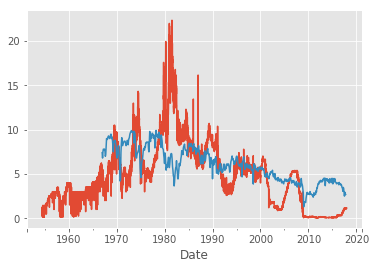

In [70]:
ffr.rename(columns={"Value": "risk_free_rate"}, inplace=True)

autos.rename(columns={"Value": "production"}, inplace=True)

ffr.risk_free_rate.plot()

autos.production.plot()

**Exercise** Do a simmlar analysis/report for whatever datasets you chose to work with. Make sure to do the following:

- Make note of the frequency of the data (e.g. daily, monthly, quarterly, yearly, etc.)
- Check the column names

If you chose to use the same data as me, do something interesting with the data. Perhaps construct plots of different variables, or compute summary statistics -- use your imagination here.

## Dates in Pandas <a id=pandas_dates></a>

Now we will look at how to use date and dateime functionality in pandas.

To begin, lets take a closer look at the type of index we have on our `ffr` and `vc` dataframes:

In [71]:
type(ffr.index)

pandas.core.indexes.datetimes.DatetimeIndex

Here we have a `DatetimeIndex`, which menas pandas recogizes this DataFrame as containing time series data. 

What can we do now? A lot, here's a brief list:

- `subset` the data using strings to get data for a particular time frame
- `resample` the data to a diffrent frequency: this means we could convert daily to monthly, quarterly, etc.
- quickly access things like `year`, `month`, and `day` for the observation
- rolling computations: this will allow us to compute statistics on a rolling subset of the data. We'll show a simple example here, but check out the [docs](http://pandas.pydata.org/pandas-docs/stable/computation.html#window-functions) for more info
- `snap` the observations to a particular frequency -- this one is a bit advanced and we won't cover it here

For a much more comprehensive list with other examples see the [docs](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#datetimeindex)

For now, let's look at how to do these things with the data we obtained from quandl

**NOTE** You can _only_ do these things when you have a `DatetimeIndex`. This means that even if one of the columns in your DataFrame has date or datetime information, you will need to set it as the index to access this functionality. 

**How to set the index as a Date:** Below is a mini-example where we set the index to be a time variable:

In [72]:
small_df = {"Date": ['1950-01-31', '1950-02-28', '1950-03-31'], "GDP": [100, 200, 300]}
small_df = pd.DataFrame(small_df)

small_df.head()

,Date,GDP
0,1950-01-31,100
1,1950-02-28,200
2,1950-03-31,300


A standard looking dataframe, but the key issue is that the data value is just another series. We want the index to be the date so we can exploit some of the functionality of Pandas. First lets verify what the index is:

In [73]:
small_df.index

RangeIndex(start=0, stop=3, step=1)

So this is just a range, not a datetime. Lets first try this:

In [74]:
small_df = small_df.set_index(small_df['Date'])

small_df.head()

small_df.index

Index(['1950-01-31', '1950-02-28', '1950-03-31'], dtype='object', name='Date')

Note that while it looks good, it is not recognized as a `DatetimeIndex` but just a regular index. This verifies it.

In [75]:
type(small_df.index)

pandas.core.indexes.base.Index

So the way to do this is to use the `pd.DatetimeIndex` which will properly convert it

In [76]:
small_df = small_df.set_index(pd.DatetimeIndex(small_df['Date'], freq = "M"))

small_df.head()

small_df.index

DatetimeIndex(['1950-01-31', '1950-02-28', '1950-03-31'], dtype='datetime64[ns]', name='Date', freq='M')

Now we have it. The index is now set as a date time with a monthly frequency. 

### subsetting 

This feature is really amazing, basicly we slice on the dataframe by just specifying the year, month, dates, etc. that we want. For example, suppose we wanted to extract all the data for the federal funds rate for the year 2008.

In [77]:
ffr2008 = ffr["2008"]
print("ffr2008 is a", type(ffr2008))
df_info(ffr2008)

ffr2008 is a <class 'pandas.core.frame.DataFrame'>
Shape:  (366, 1)
dtypes:  {'risk_free_rate': dtype('float64')}
index dtype:  datetime64[ns]


,risk_free_rate
Date,
2008-01-01,3.06
2008-01-02,4.11
2008-01-03,4.25
2008-12-29,0.10
2008-12-30,0.09
2008-12-31,0.14


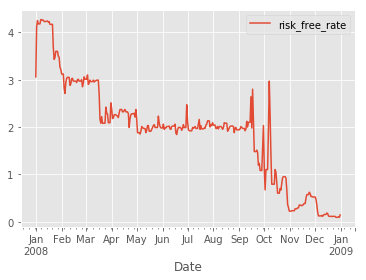

In [78]:
ffr2008.plot()

Now lets further restrict to September 2008:

Shape:  (30, 1)
dtypes:  {'risk_free_rate': dtype('float64')}
index dtype:  datetime64[ns]


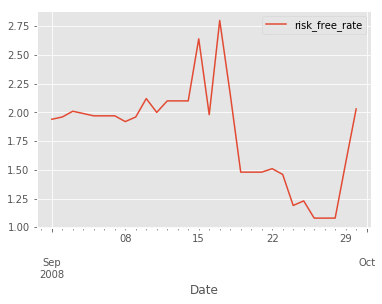

In [79]:
ffr_sep2008 = ffr["2008-09"]
df_info(ffr_sep2008)

ffr_sep2008.plot()

We can use this same functionality to extract ranges of dates. To get the data starting in june 2007 and going until march 2011 we would do

In [80]:
ffr2 = ffr["2007-06":"2011-03"]
df_info(ffr2)

Shape:  (1400, 1)
dtypes:  {'risk_free_rate': dtype('float64')}
index dtype:  datetime64[ns]


,risk_free_rate
Date,
2007-06-01,5.23
2007-06-02,5.23
2007-06-03,5.23
2011-03-29,0.13
2011-03-30,0.13
2011-03-31,0.10


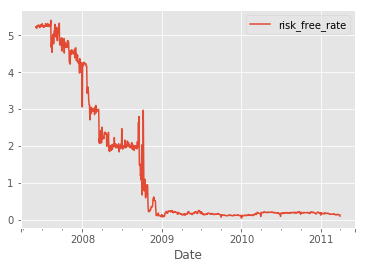

In [81]:
ffr2.plot()

### resampling

Now suppose that instead of daily data, we wanted our federal funds data at a monthly frequency or annual. Pandas has the `resample` method on our DataFrame that allows us to execute this. This is essentially a `groupby` operation that will preserve the idea that that we are operating on a time index AND provide some built in flexibility about how we want to change the freqency.

The baisc idea is just like `groupby`: we specify how we want to do (by year, quarterly, month, month start) and then specify an aggregator option, like take the mean. Lets see this

In [82]:
ffr.resample("Y").mean().head()

# M specifies the month, where it will assign the last date of that month
# so July gets the date 1954-07-31...

,risk_free_rate
Date,
1954-12-31,1.008424
1955-12-31,1.788603
1956-12-31,2.729590
1957-12-31,3.105342
1958-12-31,1.572356


Key observation, now the frequency change it is monthy. Try something different, 
- `10A` gives decadel values. 
- `Y` gives yearly
- `Q` gives quarterly
- `2w` gives bi-weekly. Note put your favorite number and see what happens.
-  The [documentation](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases) for the most common frequencies

In [83]:
ffr.resample("MS").mean().head()

# M specifies the month, where it will assign the start date of that month
# so July gets the date 1954-07-31...

,risk_free_rate
Date,
1954-07-01,0.799355
1954-08-01,1.220645
1954-09-01,1.066667
1954-10-01,0.848710
1954-11-01,0.833667


Notice that the values are the same, we just assigned the "average July value" to the first of the month. **Note the subtly here, also important to mindful about when you are lining different data sets up.** 

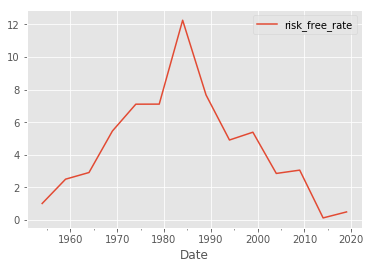

In [84]:
ffr.resample("5A").mean().plot()

Above we used the `mean` as the aggregator. Other statistics could be used. Here is an example:

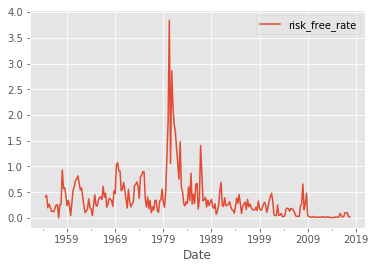

In [85]:
ffr.resample("Q").std().plot()

There are also two specific time-dimension aggregators that may be of use `first` and `last` These take the first and last values over the time period. Lets look at this...

In [86]:
ffr.resample("M").first().head()

,risk_free_rate
Date,
1954-07-31,1.13
1954-08-31,0.25
1954-09-30,1.44
1954-10-31,0.50
1954-11-30,1.38


In [87]:
ffr.resample("M").last().head()

,risk_free_rate
Date,
1954-07-31,0.25
1954-08-31,1.44
1954-09-30,1.44
1954-10-31,1.13
1954-11-30,1.38


Notice that the index is the same on both, but the data is clearly different. What is going on is that in the first dataframe, we assigned the first value of July (i.e. July 01 54) to the month of July, but used the resampled date of the last of the month. 

The next dataframe then uses the last value of July (i.e. July 31 54), and then associates it with the date of our resampled time for July which just happens to be July 31 54.

Make sense? Think about what these do:
- `ffr.resample("MS").first().head()`
- `ffr.resample("MS").last().head()`

### Access year, month, day...

Given a `DatetimeIndex` you can access the day, month, or year (also second, millisecond, etc.) by simply accessing the `.XX` property; where `XX` is the data you want

In [88]:
ffr.index.year

Int64Index([1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954,
            ...
            2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017],
           dtype='int64', name='Date', length=23171)

In [89]:
ffr.index.day

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            28, 29, 30,  1,  2,  3,  4,  5,  6,  7],
           dtype='int64', name='Date', length=23171)

In [90]:
ffr.index.month

Int64Index([ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
            ...
            11, 11, 11, 12, 12, 12, 12, 12, 12, 12],
           dtype='int64', name='Date', length=23171)

### Rolling computations

We can use pandas to do rolling computations. What does that mean? Here is an example: For example, suppose we **want** to plot the maximum and minimum of the risk free rate within the past week at each date (think about that slowly -- for every date, we want to look back 7 days and compute the max).

Here's how we can do that

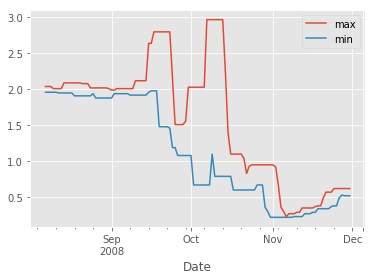

In [91]:
fig, ax = plt.subplots()

ffr["2008-8":"2008-11"].rolling(window=7).max().plot(ax=ax)
ffr["2008-8":"2008-11"].rolling(window=7).min().plot(ax=ax)

ax.legend(["max","min"])

**Note that this is different from just resampling** because we will have an observation for every date in the original dataframe (except the number of dates at the front needed to construct the initial window).

In [92]:
ffr.rolling(window=7).max().head(10)

,risk_free_rate
Date,
1954-07-01,NaN
1954-07-02,NaN
1954-07-03,NaN
1954-07-04,NaN
1954-07-05,NaN
1954-07-06,NaN
1954-07-07,1.25
1954-07-08,1.25
1954-07-09,1.25


In [93]:
ffr.resample("7D").max().head(10)

,risk_free_rate
Date,
1954-07-01,1.25
1954-07-08,1.25
1954-07-15,0.75
1954-07-22,0.75
1954-07-29,0.38
1954-08-05,1.44
1954-08-12,1.44
1954-08-19,1.44
1954-08-26,1.44


### Merging with dates

Let's see what happens when we merge the ffr and vc datasets

In [94]:
# do a left merge on the index (date info)
df = pd.merge(ffr, autos, left_index=True, right_index=True, how="left")
df_info(df)

Shape:  (23171, 2)
dtypes:  {'risk_free_rate': dtype('float64'), 'production': dtype('float64')}
index dtype:  datetime64[ns]


,risk_free_rate,production
Date,,
1954-07-01,1.13,NaN
1954-07-02,1.25,NaN
1954-07-03,1.25,NaN
2017-12-05,1.16,NaN
2017-12-06,1.16,NaN
2017-12-07,1.16,NaN


In [96]:
autos.head()

,production
Date,
1967-01-31,7.4
1967-02-28,6.8
1967-03-31,7.5
1967-04-30,7.8
1967-05-31,7.8


Notice that we ended up with a lot of missing data. This happened for two reasons:

1. The ffr data goes back to 1954, but the autos data starts in 1967
2. The ffr data is at a daily frequency, but autos is monthly.

To resolve the first issue we can subset the ffr data and only keep from 1985 on

In [97]:
ffr_recent = ffr["1985":]

To resolve the second issue we could do a couple of things. One interesting possibility will find some place in the middle:

1. resample the `ffr` data to a weekly frequency
2. resample the `autos` data to a weekly frequency by _padding_. This is called upsampling because we are going from a lower frequency (monthly) to a higher one (weekly). **Note** I would be mindful about performing any kind of formal analysis on padded data, as this is essentially filling in unknown data points. Its nice for making graphs, but be careful. 

In [98]:
ffr_recentM = ffr_recent.resample("W").mean()
autos_M = autos.resample("W").pad()

In [99]:
autos_M.head(10)

,production
Date,
1967-02-05,7.4
1967-02-12,7.4
1967-02-19,7.4
1967-02-26,7.4
1967-03-05,6.8
1967-03-12,6.8
1967-03-19,6.8
1967-03-26,6.8
1967-04-02,7.5


Notice that using `pad` here just copied data forwards to fill in missing months (e.g. the data for March 1985 was applied to April and May)

Now let's try that merge again

In [100]:
df = pd.merge(ffr_recentM, autos_M, left_index=True, right_index=True, how="left")
print(df.head(6))
print("\n\n", df.tail(8))

            risk_free_rate  production
Date                                  
1985-01-06        8.570000      7.9119
1985-01-13        8.214286      7.9119
1985-01-20        8.180000      7.9119
1985-01-27        8.312857      7.9119
1985-02-03        8.667143      8.2634
1985-02-10        8.438571      8.2634


             risk_free_rate  production
Date                                  
2017-10-22        1.160000      2.6614
2017-10-29        1.160000      2.6614
2017-11-05        1.147143      2.6977
2017-11-12        1.160000         NaN
2017-11-19        1.160000         NaN
2017-11-26        1.160000         NaN
2017-12-03        1.147143         NaN
2017-12-10        1.160000         NaN


That looks much better.

Let's try to do something interesting with this data. I want to plot rolling max and min of the risk free rate during the financial crisis. The spread between the two will give us a sense of the amount of volatility in the financial markets. Second, I want to plot auto sales over that same time **on top of the same graph** so you have two y-axis, one on the left, another on the right for each series. 

Text(0,0.5,'\n Auto Production (Millions), Black')

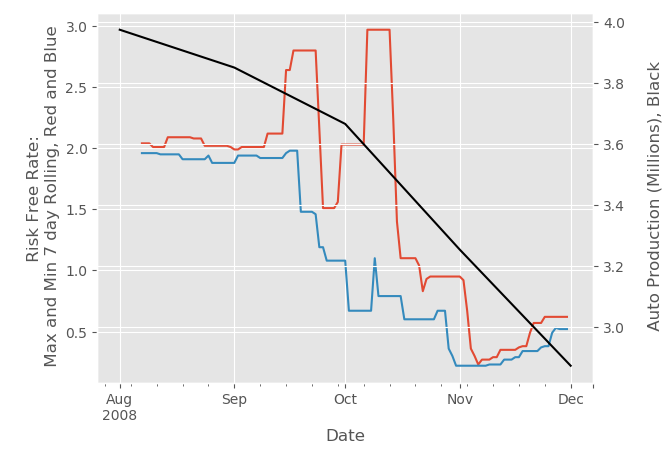

In [141]:
plt.style.use("ggplot")

fig, ax = plt.subplots()

ffr["2008-8":"2008-11"].rolling(window=7).max().plot(ax=ax, legend = False)
ffr["2008-8":"2008-11"].rolling(window=7).min().plot(ax=ax, legend = False)

ax.set_ylabel('\n Risk Free Rate: \n Max and Min 7 day Rolling, Red and Blue')

ax2 = ax.twinx() # This is the key command which creates a "twin" for the 
                 # axis, then we use this ax2 for ploting auto sales

autos["2008-8":"2008-12"].plot(ax=ax2, color = 'k', legend = False)

ax2.set_ylabel('\n Auto Production (Millions), Black')

In [124]:
#import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)